### Weighted Procedures A/B Testing
In multiple testing, weighted procedures are used for various reasons. In this case, we investigate how weights might affect the set of discoveries. For now, we make no assumption about how many true nulls or alternatives there are.

In [30]:
import numpy as np
from statistics import mean 
from scipy.stats import norm
import matplotlib.pyplot as plt
import math
import pandas as pd
from operator import itemgetter

### Background, Proposed solution
Suppose we want to test N hypotheses. For example, we might be testing N different treatments for a disease, or we might be running N industrial A/B tests. Assign each hypothesis a weight $w_i\geq 0$ so that the family of weights obeys $\frac{1}{N}\Sigma_{i=1}^{N}w_i = 1$. Suppose that for every hypothesis we have computed a p-value $P_i$. As usual, assume that the p-values corresponding to true nulls are uniformly distributed: <br/><br/>
<div align="center"> If $P_i$ corresponds to a null, $\mathbb{P}(P_i \leq u) = u$, for all $u\in [0,1]$ 
</div>

Consider the procedure that makes a discovery if $\frac{P_i}{w_i} \leq \frac{\alpha}{N}$, and makes
no discovery if $w_i = 0$

### Theoretical Proof
Let's first prove it theoretically that the procedure above controls the the probability of at least one false discovery (i.e. the FWER) under level $\alpha$

Denote $\{E_i\}$ as the event that a false discovery is made. <br/><br/>
FWER $ = P(\bigcup_{i=1}^{N}\{E_i = 1\})\\ 
\leq \sum_{i=1}^{N} P(E_i = 1) = \sum_{i=1}^{N}P(\frac{P_i}{w_i} < \frac{\alpha}{N}) \\
\leq \sum_{i=1}^{N}\frac{\alpha w_i}{N} = \alpha\sum_{i=1}^{N}\frac{w_i}{N} = \alpha$ <br/> by how we define $w_i, P_i$.  

- Notes: When all $w_i$ is exactly one, it becomes a Bonferroni Correction. <br/> When a certain $w_i > 1$, it represents a less control of FDP(false discovery proportion) than standard(tends to have a higher FDP on $i^{th}$ event);<br/> When a certain $w_i < 1$, it represents a more control of FDP than standard(tends to have a lower FDP on $i^{th}$ event)

### Simulations
Consider $Z \sim N(\mu, I) \in \mathbb{R}^{500}$, where
<div align="center"> $\mu_i = \begin{cases} 
      0 & 1\leq i \leq 450 \\
      \frac{i-450}{5} & 451 \leq i \leq 500
   \end{cases}$
</div>


For each i,we want to test whether the null is true $\mu_i = 0$ or the alternative $\mu_i > 0$.<br> To do so, we compute the $i^{th}$ p-value as $P_i = \Phi(-Z_i)$, where $\Phi$ is the standard Gaussian $N(0,1)$ CDF. <br/><br/>
We'll go through the following testing procedures and see how each control methods work:
1. "Uncorrected" testing. Like regular decisions, reject a hypothesis if $P_i \leq \alpha$, where $\alpha$ is fixed.
2. Bonferroni Procedure.
3. Benjamini-Hochberg Procedure.
4. Weighted Procedure from the above proposed solution, with $w_i = \frac{2i}{501}$.
5. Weighted Procedure from the above proposed solution, with $w_i = \frac{2(501-i)}{501}$.
6. Weighted Procedure from the above proposed solution, with $w_i = 0.5$ for $1\leq i\leq 450$ and $w_i = 5.5$ for $i\geq 450$.

For each of the six methods, repeat the experiment 100 times. Over these 100 trials, we'll compute and plot the average number of rejections, average number of true rejections, and achieved false discovery rate, against
$\alpha \in\{0.001, 0.005, 0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5\}$ 

#### Method1: Uncorrected

In [9]:
class uncorrected:
    # init method or constructor   
    def __init__(self, sampleQuantity = 100):  
        """ This method is to randomly generate the 500 Zi based on the mu_i given above,
            and generate their p-value accordingly
            
        Parameters:
        -----------
        sampleQuantity: The quantity of this experiments, default is set to 100 as described
        
        """
        self.testQuantity = sampleQuantity
        
        rows, cols = (self.testQuantity, 500) 
        
        
        ## get a 100*500 dimensions matrix, storing the values & pvalues of experiment 1-100 and index 1-500
        self.values = [[0]*cols]*rows 
        self.pvalues = [[0]*cols]*rows
        
        for row in range(rows):
            self.values[row] = np.concatenate((np.random.normal(0,1,450), np.random.normal( np.delete(np.arange(51),0)/5, 1, 50)), axis=None)
            self.pvalues[row] = norm.cdf(-self.values[row])
        
    
    def decision_alpha(self, alpha):
        """ This method count the decisions made based on alpha given.
        
        Parameters:
        ----------
        alpha: The significance level as defined above
        
        Storing:
        ----------
        disPhase1: # of discoveries in phase I, i in 1-450.
        disPhase2: # of discoveries in phase II, i in 451 - 500.
        """
        ## store the # discoveries of each experiment at phaseI(0<i<=450) and phaseII (450<i<=500) 
        self.disPhase1 = np.zeros(self.testQuantity)
        self.disPhase2 = np.zeros(self.testQuantity)
        
        for row in range(self.testQuantity):
            for i in range(450):
                if self.pvalues[row][i] < alpha:
                    self.disPhase1[row] += 1
            
            for k in range(450,500):
                if self.pvalues[row][k] < alpha:
                    self.disPhase2[row] += 1
                    
    def total_rejection(self):
        """ This method calculates the average total rejections given the cuurent disPhase1 & disPhase2.
        
        Returns:
        ----------
        total_rej: # of average total rejections of the 100 experiments given the current alpha.
        """
        return mean(self.disPhase1 + self.disPhase2)
    
    def total_true_rejection(self):
        """ This method calculates the average total TRUE rejections given the cuurent disPhase1 & disPhase2.
        
        Returns:
        ----------
        total_rej: # of average total rejections of the 100 experiments given the current alpha.
        """
        return mean(self.disPhase2)
    
    def FDR(self):
        """ This method calculates the average total TRUE rejections given the cuurent disPhase1 & disPhase2.
        
        Returns:
        ----------
        total_rej: # of average total rejections of the 100 experiments given the current alpha.
        """
        return mean(self.disPhase1)/mean(self.disPhase1 + self.disPhase2)
        

In [10]:
def store_graph_metrics(alpha, allData):
    """ This method calculate and store the total rejections and total rejections over all alpha input.
    
    Parameters:
    ----------
    alpha: list of alpha want to test out.
    allData: the object holds all the values and pvalues
    
    Returns:
    ----------
    total_rej_list: list of # of average total rejections of the 100 experiments over all alpha.
    true_rej_list: list of # of average true rejections of the 100 experiments over all alpha.
    FDR_list: list of # of FDR of the 100 experiments over all alpha.
    """
    n = len(alpha)
    
    total_rej_list,true_rej_list,FDR_list = np.zeros(n),np.zeros(n),np.zeros(n)
    for i in range(n):
        allData.decision_alpha(alpha[i])
        total_rej_list[i] = allData.total_rejection()
        true_rej_list[i] = allData.total_true_rejection()
        FDR_list[i] = allData.FDR()
        
    return total_rej_list, true_rej_list, FDR_list
    

In [11]:
meth1_data = uncorrected()

In [12]:
alpha = list([0.001,0.005,0.01,0.05,0.1,0.2,0.3,0.4,0.5])
metrics_uncorrected = store_graph_metrics(alpha, meth1_data)

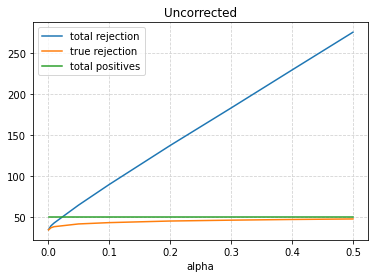

In [104]:
plt.plot(alpha, metrics_uncorrected[0], label= "total rejection")
# add a red subplot that shares the x-axis with ax1
plt.plot(alpha, metrics_uncorrected[1],label = "true rejection")
plt.plot(alpha, [50,50,50,50,50,50,50,50,50],label = "total positives")
plt.xlabel("alpha")
plt.legend()
plt.title("Uncorrected")
plt.grid(color='lightgray',linestyle='--')
plt.show()

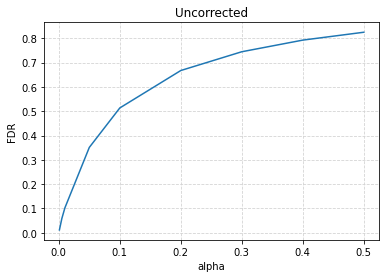

In [14]:
plt.plot(alpha, metrics_uncorrected[2])
plt.xlabel("alpha")
plt.ylabel("FDR")
plt.title("Uncorrected")
plt.grid(color='lightgray',linestyle='--')
plt.show()

#### Method2: Bonferroni Correction
The idea of Bonferroni Correction is very simple, simply change the rejection criteria from "$< \alpha$" to "$< \frac{\alpha}{N}$", where when $w_i$ defined above is exactly 1.<br/>
Since all the procedures are same except we redefine the decision process, we'll overwrite the uncorrected class above.

In [19]:
class Bonferroni(uncorrected):
    def decision_alpha(self, alpha):
        """ This method count the decisions made based on alpha given.
        
        Parameters:
        ----------
        alpha: The significance level as defined above
        
        Storing:
        ----------
        disPhase1: # of discoveries in phase I, i in 1-450.
        disPhase2: # of discoveries in phase II, i in 451 - 500.
        """
        ## store the # discoveries of each experiment at phaseI(0<i<=450) and phaseII (450<i<=500) 
        self.disPhase1 = np.zeros(self.testQuantity)
        self.disPhase2 = np.zeros(self.testQuantity)
        
        for row in range(self.testQuantity):
            for i in range(450):
                if self.pvalues[row][i] < alpha/500:
                    self.disPhase1[row] += 1
            
            for k in range(450,500):
                if self.pvalues[row][k] < alpha/500:
                    self.disPhase2[row] += 1

In [20]:
meth2_data = Bonferroni()

In [21]:
metrics_Bonferroni = store_graph_metrics(alpha, meth2_data)

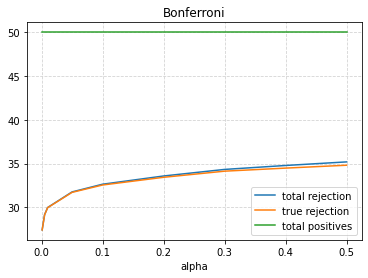

In [103]:
plt.plot(alpha, metrics_Bonferroni[0], label= "total rejection")
# add a red subplot that shares the x-axis with ax1
plt.plot(alpha, metrics_Bonferroni[1],label = "true rejection")
plt.plot(alpha, [50,50,50,50,50,50,50,50,50],label = "total positives")
plt.xlabel("alpha")
plt.legend()
plt.title("Bonferroni")
plt.grid(color='lightgray',linestyle='--')
plt.show()

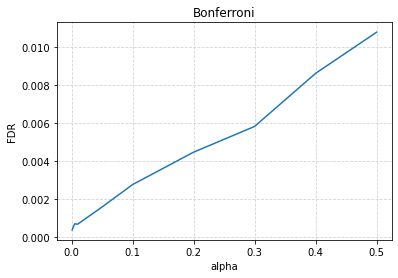

In [23]:
plt.plot(alpha, metrics_Bonferroni[2])
plt.xlabel("alpha")
plt.ylabel("FDR")
plt.title("Bonferroni")
plt.grid(color='lightgray',linestyle='--')
plt.show()

#### Method3: Benjamini-Hochberg
Benjamini-Hochberg work as followed described in Wikipedia: <br/>
1. For a given $\alpha$ , find the largest k such that $P_{(k)} \leq \frac{k}{m}\alpha$
2. Reject the null hypothesis (i.e., declare discoveries) for all $H_{(i)}$ for $i = 1,2,...,k$

we redefine the decision process by Benjamini-Hochberg, we'll overwrite the uncorrected class above.

In [53]:
class Benjamini_Hochberg(uncorrected):
    
    def decision_alpha(self, alpha):
        """ This method count the decisions made based on alpha given.
        
        Parameters:
        ----------
        alpha: The significance level as defined above
        
        Storing:
        ----------
        disPhase1: # of discoveries in phase I, i in 1-450.
        disPhase2: # of discoveries in phase II, i in 451 - 500.
        """
        ## store the # discoveries of each experiment at phaseI(0<i<=450) and phaseII (450<i<=500) 
        self.disPhase1 = np.zeros(self.testQuantity)
        self.disPhase2 = np.zeros(self.testQuantity)
        
        corrected_alpha = self.BH_helper(self.pvalues, alpha)
        
        for row in range(self.testQuantity):
            for i in range(450):
                if self.pvalues[row][i] < corrected_alpha[row]:
                    self.disPhase1[row] += 1
            
            for k in range(450,500):
                if self.pvalues[row][k] < corrected_alpha[row]:
                    self.disPhase2[row] += 1
    
    def BH_helper(self, p_values,alpha):
        """ This method input the alpha and p_values, and returns the decision threshold by Benjamini-Hochberg.
        
        Parameters:
        ----------
        p_values: all p-values as a 100*500 matrix
        alpha: intended alpha without correction
        
        Returns:
        ----------
        A list of Corrected alpha by Benjamini-Hochberg based on the # of experiments.
        """
        experiment = len(p_values)
        
        m = 500
        
        p_sorted = np.sort(p_values)
        
        corrected_alpha = np.zeros(experiment)
        
        for ex in range(experiment):
            for j in range(m):
                if p_sorted[ex][j] <= (j+1)*alpha/m:
                    largest_k = j
            corrected_alpha[ex] = p_sorted[ex][largest_k]
                    
        
        return corrected_alpha
    
                

In [54]:
meth3_data = Benjamini_Hochberg()

In [55]:
metrics_BH = store_graph_metrics(alpha, meth3_data)

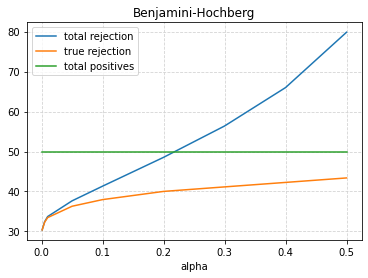

In [102]:
plt.plot(alpha, metrics_BH[0], label= "total rejection")
# add a red subplot that shares the x-axis with ax1
plt.plot(alpha, metrics_BH[1],label = "true rejection")
plt.plot(alpha, [50,50,50,50,50,50,50,50,50],label = "total positives")
plt.xlabel("alpha")
plt.legend()
plt.title("Benjamini-Hochberg")
plt.grid(color='lightgray',linestyle='--')
plt.show()

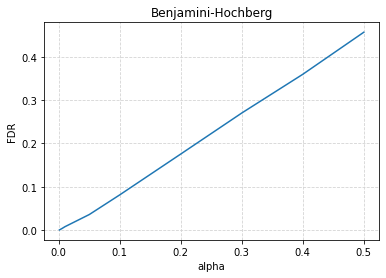

In [83]:
plt.plot(alpha, metrics_BH[2])
plt.xlabel("alpha")
plt.ylabel("FDR")
plt.title("Benjamini-Hochberg")
plt.grid(color='lightgray',linestyle='--')
plt.show()

#### Method4: Weighted Procedure with $w_i = \frac{2i}{501}$.
we redefine the decision process by weighted I, we'll overwrite the uncorrected class above.

In [67]:
class weightI(uncorrected):
    def decision_alpha(self, alpha):
        """ This method count the decisions made based on alpha given.
        
        Parameters:
        ----------
        alpha: The significance level as defined above
        
        Storing:
        ----------
        disPhase1: # of discoveries in phase I, i in 1-450.
        disPhase2: # of discoveries in phase II, i in 451 - 500.
        """
        ## store the # discoveries of each experiment at phaseI(0<i<=450) and phaseII (450<i<=500) 
        self.disPhase1 = np.zeros(self.testQuantity)
        self.disPhase2 = np.zeros(self.testQuantity)
        
        for row in range(self.testQuantity):
            for i in range(450):
                if self.pvalues[row][i] < (alpha/500) * (2*(i+1)/501):
                    self.disPhase1[row] += 1
            
            for k in range(450,500):
                if self.pvalues[row][k] < (alpha/500) * (2*(k+1)/501):
                    self.disPhase2[row] += 1

In [68]:
meth4_data = weightI()

In [69]:
metrics_weightI = store_graph_metrics(alpha, meth4_data)

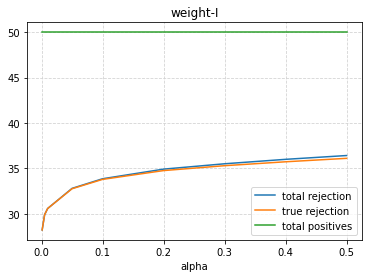

In [101]:
plt.plot(alpha, metrics_weightI[0], label= "total rejection")
# add a red subplot that shares the x-axis with ax1
plt.plot(alpha, metrics_weightI[1],label = "true rejection")
plt.plot(alpha, [50,50,50,50,50,50,50,50,50],label = "total positives")
plt.xlabel("alpha")
plt.legend()
plt.title("weight-I")
plt.grid(color='lightgray',linestyle='--')
plt.show()

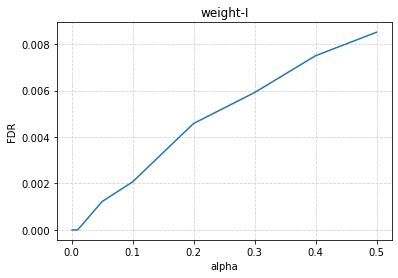

In [71]:
plt.plot(alpha, metrics_weightI[2])
plt.xlabel("alpha")
plt.ylabel("FDR")
plt.title("weight-I")
plt.grid(color='lightgray',linestyle='--')
plt.show()

#### Method5: Weighted Procedure with  $w_i = \frac{2(501-i)}{501}$.
we redefine the decision process by weighted II, we'll overwrite the uncorrected class above.

In [72]:
class weightII(uncorrected):
    def decision_alpha(self, alpha):
        """ This method count the decisions made based on alpha given.
        
        Parameters:
        ----------
        alpha: The significance level as defined above
        
        Storing:
        ----------
        disPhase1: # of discoveries in phase I, i in 1-450.
        disPhase2: # of discoveries in phase II, i in 451 - 500.
        """
        ## store the # discoveries of each experiment at phaseI(0<i<=450) and phaseII (450<i<=500) 
        self.disPhase1 = np.zeros(self.testQuantity)
        self.disPhase2 = np.zeros(self.testQuantity)
        
        for row in range(self.testQuantity):
            for i in range(450):
                if self.pvalues[row][i] < (alpha/500) * (2*(501-(i+1))/501):
                    self.disPhase1[row] += 1
            
            for k in range(450,500):
                if self.pvalues[row][k] < (alpha/500) * (2*(501-(k+1))/501):
                    self.disPhase2[row] += 1

In [73]:
meth5_data = weightII()

In [74]:
metrics_weightII = store_graph_metrics(alpha, meth5_data)

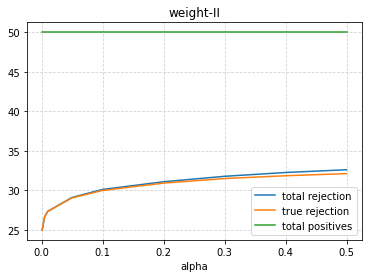

In [100]:
plt.plot(alpha, metrics_weightII[0], label= "total rejection")
# add a red subplot that shares the x-axis with ax1
plt.plot(alpha, metrics_weightII[1],label = "true rejection")
plt.plot(alpha, [50,50,50,50,50,50,50,50,50],label = "total positives")
plt.xlabel("alpha")
plt.legend()
plt.title("weight-II")
plt.grid(color='lightgray',linestyle='--')
plt.show()

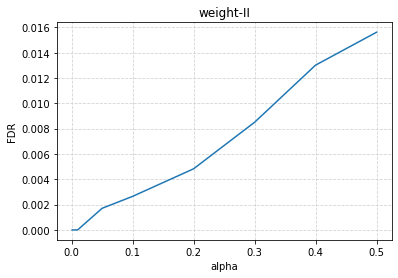

In [77]:
plt.plot(alpha, metrics_weightII[2])
plt.xlabel("alpha")
plt.ylabel("FDR")
plt.title("weight-II")
plt.grid(color='lightgray',linestyle='--')
plt.show()

#### Method6: Weighted Procedure with  $w_i = 0.5$ for $1\leq i\leq 450$ and $w_i = 5.5$ for $i\geq 450$.
we redefine the decision process by weighted III, we'll overwrite the uncorrected class above.

In [92]:
class weightIII(uncorrected):
    def decision_alpha(self, alpha):
        """ This method count the decisions made based on alpha given.
        
        Parameters:
        ----------
        alpha: The significance level as defined above
        
        Storing:
        ----------
        disPhase1: # of discoveries in phase I, i in 1-450.
        disPhase2: # of discoveries in phase II, i in 451 - 500.
        """
        ## store the # discoveries of each experiment at phaseI(0<i<=450) and phaseII (450<i<=500) 
        self.disPhase1 = np.zeros(self.testQuantity)
        self.disPhase2 = np.zeros(self.testQuantity)
        
        for row in range(self.testQuantity):
            for i in range(450):
                if self.pvalues[row][i] < (alpha/500) * 0.5:
                    self.disPhase1[row] += 1
            
            for k in range(450,500):
                if self.pvalues[row][k] < (alpha/500) * 5.5:
                    self.disPhase2[row] += 1

In [96]:
meth6_data = weightIII()

metrics_weightIII = store_graph_metrics(alpha, meth6_data)

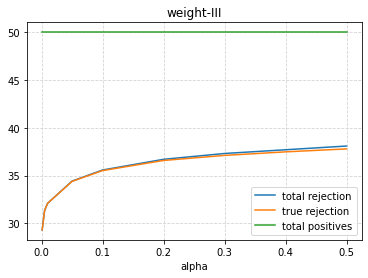

In [99]:
plt.plot(alpha, metrics_weightIII[0], label= "total rejection")
# add a red subplot that shares the x-axis with ax1
plt.plot(alpha, metrics_weightIII[1],label = "true rejection")
plt.plot(alpha, [50,50,50,50,50,50,50,50,50],label = "total positives")
plt.xlabel("alpha")
plt.legend()
plt.title("weight-III")
plt.grid(color='lightgray',linestyle='--')
plt.show()

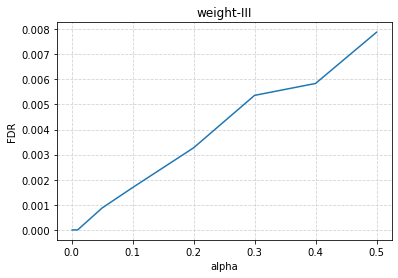

In [98]:
plt.plot(alpha, metrics_weightIII[2])
plt.xlabel("alpha")
plt.ylabel("FDR")
plt.title("weight-III")
plt.grid(color='lightgray',linestyle='--')
plt.show()

### Summary
The 3 weighted methods turn out to be similar to Bonferroni Correction at different level, which intuitively makes sense from the formula.<br/><br/>
The uncorrected method's FDR is growing up fast(a bad thing) as $\alpha$ goes up. By contrast, the weighted and Bonferroni controls the FDR pretty nicely, at around 1% level. The good part of uncorrected method is that its sensitivity grows to almost 100% when we increase $\alpha$. There's always a trade off between sensistivity and FDR, Benjamini-Hochberg sort of lies between the weighted method and Bonferroni correction.<br/>

**FDR**: Uncorrected > Benjamini_Hochberg > Weighted/Bonferroni<br/>
**Sensitivity**: Uncorrected > Benjamini_Hochberg > Weighted/Bonferroni<br/>

